In [1]:
import sys
import pandas as pd
import numpy as np
import ipyvolume as ipv
from scipy import optimize

import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue import config

from tyssue import Monolayer, Sheet
from tyssue import MonoLayerGeometry as geom
from tyssue.dynamics import BulkModel as model
from tyssue.generation import three_faces_sheet, extrude
from tyssue.topology.bulk_topology import IH_transition, HI_transition

from datetime import datetime
from tyssue.draw import highlight_cells

from tyssue.draw import sheet_view
from tyssue.io import hdf5

/home/guillaume/miniconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/guillaume/miniconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:


specs = config.geometry.bulk_spec()

sheet = Sheet.planar_sheet_3d('flat', 4, 5, 1, 1)
sheet.sanitize()
datasets = extrude(sheet.datasets, method='translation')
mono = Monolayer('mono', datasets, specs)

geom.center(mono)
geom.update_all(mono)

dyn_specs = config.dynamics.quasistatic_bulk_spec()
dyn_specs['cell']['area_elasticity'] = 0.05
dyn_specs['cell']['prefered_area'] = 6.
dyn_specs['cell']['vol_elasticity'] = 1.
dyn_specs['cell']['prefered_vol'] = 1.2
dyn_specs['face']['contractility'] = 0.0
dyn_specs['edge']['line_tension'] = 0.0


mono.update_specs(dyn_specs, reset=True)


mono.face_df.loc[mono.apical_faces, 'contractility'] = 1e-3
mono.face_df.loc[mono.basal_faces, 'contractility'] = 1e-3

res = Solver.find_energy_min(mono, geom, model)



Reseting column is_alive of the cell dataset with new specs
Reseting column is_alive of the face dataset with new specs
Reseting column is_active of the edge dataset with new specs
Reseting column is_active of the vert dataset with new specs


In [3]:

def view3d(mono):
    ipv.clear()
    draw_spec = config.draw.sheet_spec()
    draw_spec['face']['visible'] = True 
    draw_spec['face']['color'] = mono.face_df.area
    draw_spec['face']['color_range'] = (0, 1)
    # function plotting two meshes
    fig, meshes = sheet_view(mono, mode='3D', **draw_spec)
    fig = ipv.gcf()

    #mesh = ipv.examples.klein_bottle(show=False)
    #fig.meshes = fig.meshes + [mesh, ]
    fig.anglex = 1.0
    fig.angley = 0.2
    fig.anglez = 0.1
    
    ipv.show()
    #timestamp = datetime.now().isoformat().replace(':', '').replace('.', '_')
    #ipv.savefig(f'{mono.identifier}_{timestamp}.png')


In [4]:
view3d(mono)

In [5]:
for i in range(6):
    mono.face_df.loc[4, 'contractility'] *= 2
    res = Solver.find_energy_min(mono, geom, model)

In [6]:
highlight_cells(mono, 4)
view3d(mono)

In [7]:
ab_edges_ = ((mono.upcast_srce(mono.vert_df['segment'])
             != mono.upcast_trgt(mono.vert_df['segment'])) 
            & (mono.edge_df['cell'] == 4))

ab_edges = mono.edge_df[ab_edges_].index

mono.edge_df.loc[ab_edges, 'line_tension'] = 1e-2



In [8]:
prev_nums = mono.Nv, mono.Ne, mono.Nf

In [9]:
while mono.face_df.loc[4, 'num_sides'] > 3:
    e_min = mono.edge_df[mono.edge_df['face'] == 4]['length'].idxmin()
    prev_nums = {'edge': mono.Ne,
                 'face': mono.Nf,
                 'vert': mono.Nv}
    
    mono.settings['threshold_length'] = 1e-3
    IH_transition(mono, e_min)
    mono.face_df.loc[prev_nums['face']:, 'contractility'] = 0
    
    
    geom.update_all(mono)
    res = Solver.find_energy_min(mono, geom, model)

In [10]:
highlight_cells(mono, 4, reset_visible=True)
view3d(mono)

In [16]:
mono.cell_df.loc[4, 'prefered_vol'] *= 0.4
mono.cell_df.loc[4, 'prefered_area'] *= 0.4**(2/3)

prev_nums = {'edge': mono.Ne,
             'face': mono.Nf,
             'vert': mono.Nv}
HI_transition(mono, 4)
geom.update_all(mono)
mono.face_df.loc[prev_nums['face']:, 'contractility'] = 0

res = Solver.find_energy_min(mono, geom, model)

ValueError: Only three sided faces can undergo a H-I transition

In [18]:
highlight_cells(mono, 4, reset_visible=True)

view3d(mono)

In [19]:
from tyssue.topology.bulk_topology import find_rearangements

In [20]:
find_rearangements(mono)

({66,
  67,
  68,
  69,
  137,
  139,
  145,
  147,
  150,
  152,
  153,
  155,
  175,
  181,
  189,
  191,
  206,
  208,
  209,
  211,
  251,
  257,
  275,
  281},
 {44, 45, 46, 47})

In [17]:
mono.cell_df.loc[4, 'prefered_vol'] *= 0.4
mono.cell_df.loc[4, 'prefered_area'] *= 0.4**(2/3)

prev_nums = {'edge': mono.Ne,
             'face': mono.Nf,
             'vert': mono.Nv}
#HI_transition(mono, 4)
geom.update_all(mono)
mono.face_df.loc[prev_nums['face']:, 'contractility'] = 0

res = Solver.find_energy_min(mono, geom, model)

In [14]:
from tyssue.topology.sheet_topology import cell_division as face_division

In [17]:
daughter = face_division(mono, 12, geom)

In [16]:
daughter2 = face_division(mono, daughter, geom)

In [22]:
mono.cell_df.loc[4, 'prefered_area'] /= 0.4**(2/3)

In [23]:
res = Solver.find_energy_min(mono, geom, model)


highlight_cells(mono, 4, reset_visible=True)

view3d(mono)

VBox(children=(Figure(anglex=1.0, angley=0.2, anglez=0.1, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[ 2,  0],
       [ 1,  2],
       [ 3,  6],
       [ 4,  3],
       [ 5,  4],
       [ 5,  7],
       [ 7,  5],
       [ 6,  7],
       [ 7,  6],
       [ 0,  8],
       [ 8,  9],
       [ 2, 48],
       [48,  2],
       [ 8, 55],
       [55,  8],
       [12, 10],
       [10, 11],
       [ 9, 12],
       [50, 10],
       [10, 50],
       [11,  5],
       [ 7, 50],
       [50,  7],
       [13, 15],
       [13, 14],
       [14, 13],
       [14, 16],
       [16, 14],
       [15, 17],
       [17, 16],
       [ 6, 13],
       [52, 14],
       [14, 52],
       [19, 18],
       [20, 19],
       [16, 20],
       [18,  1],
       [48, 19],
       [19, 48],
       [21, 23],
       [23, 22],
       [27, 24],
       [24, 25],
       [25, 26],
       [28, 26],
       [26, 28],
       [28, 27],
       [27, 28],
       [29, 21],
       [30, 29],
       [31, 23],
       [23, 31],
       [33, 29],
       [29, 33],
       [33, 31],
       [31, 33],
       [35, 37],
       [36, 35],
       [37, 30],
       [34, 60],
       [60, 34],
       [35, 34],
       [34, 35],
       [26, 36],
       [32, 28],
       [28, 32],
       [34, 32],
       [32, 34],
       [39, 31],
       [31, 39],
       [38, 32],
       [32, 38],
       [39, 56],
       [56, 39],
       [42, 40],
       [41, 40],
       [40, 41],
       [43, 41],
       [41, 43],
       [44, 42],
       [43, 44],
       [40, 27],
       [41, 38],
       [38, 41],
       [45, 46],
       [46, 47],
       [47, 43],
       [22, 45],
       [46, 39],
       [39, 46],
       [ 0,  2],
       [ 2, 23],
       [23, 21],
       [21,  0],
       [ 2,  1],
       [ 1, 22],
       [22, 23],
       [23,  2],
       [ 6,  3],
       [ 3, 24],
       [24, 27],
       [27,  6],
       [ 3,  4],
       [ 4, 25],
       [25, 24],
       [24,  3],
       [ 4,  5],
       [ 5, 26],
       [26, 25],
       [25,  4],
       [ 7,  5],
       [ 5, 26],
       [26, 28],
       [28,  7],
       [ 5,  7],
       [ 7, 28],
       [28, 26],
       [26,  5],
       [ 7,  6],
       [ 6, 27],
       [27, 28],
       [28,  7],
       [ 6,  7],
       [ 7, 28],
       [28, 27],
       [27,  6],
       [ 8,  0],
       [ 0, 21],
       [21, 29],
       [29,  8],
       [ 9,  8],
       [ 8, 29],
       [29, 30],
       [30,  9],
       [48,  2],
       [ 2, 23],
       [23, 31],
       [31, 49],
       [ 2, 48],
       [49, 31],
       [31, 23],
       [23,  2],
       [55,  8],
       [ 8, 29],
       [29, 33],
       [33, 54],
       [ 8, 55],
       [54, 33],
       [33, 29],
       [29,  8],
       [49, 31],
       [31, 33],
       [33, 54],
       [54, 33],
       [33, 31],
       [31, 49],
       [10, 12],
       [12, 37],
       [37, 35],
       [35, 10],
       [11, 10],
       [10, 35],
       [35, 36],
       [36, 11],
       [12,  9],
       [ 9, 30],
       [30, 37],
       [37, 12],
       [54, 33],
       [60, 34],
       [34, 51],
       [51, 34],
       [34, 60],
       [33, 54],
       [10, 50],
       [51, 34],
       [34, 35],
       [35, 10],
       [50, 10],
       [10, 35],
       [35, 34],
       [34, 51],
       [ 5, 11],
       [11, 36],
       [36, 26],
       [26,  5],
       [50,  7],
       [ 7, 28],
       [28, 32],
       [32, 51],
       [ 7, 50],
       [51, 32],
       [32, 28],
       [28,  7],
       [51, 32],
       [32, 34],
       [34, 51],
       [51, 34],
       [34, 32],
       [32, 51],
       [49, 31],
       [31, 39],
       [39, 49],
       [49, 39],
       [39, 31],
       [31, 49],
       [51, 32],
       [32, 38],
       [38, 53],
       [53, 38],
       [38, 32],
       [32, 51],
       [53, 38],
       [56, 39],
       [39

In [16]:
mono.edge_df[mono.edge_df['face']==12]

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,cell,cx,cy,cz,sub_vol,sub_area,line_tension,ux,uy,uz
edge,,,,,,,,,,,,,,,,,,,,,
54,31,-0.515912,0.992057,12,33,-0.225676,0.955841,-0.648301,-0.606740,-0.873977,...,4,-0.258097,0.039806,-0.521983,0.012217,0.260903,0.0,-0.227482,0.963493,0.141182
59,33,-0.000188,0.000252,12,34,-0.000220,0.000124,-0.648082,-0.606863,-0.648301,...,4,-0.258097,0.039806,-0.521983,0.000004,0.000094,0.0,-0.870773,0.489926,0.041550
67,34,-0.536294,1.069021,12,32,-1.024878,-0.296337,0.376797,-0.310526,-0.648082,...,4,-0.258097,0.039806,-0.521983,0.012774,0.268785,0.0,-0.958707,-0.277204,-0.063545
69,39,-0.517766,1.022026,12,31,0.948877,0.347853,-0.873977,0.349101,0.074901,...,4,-0.258097,0.039806,-0.521983,0.012395,0.262021,0.0,0.928428,0.340356,-0.148925
70,32,-0.537631,1.054606,12,38,0.301811,-1.007325,0.074986,0.696799,0.376797,...,4,-0.258097,0.039806,-0.521983,0.012932,0.269781,0.0,0.286183,-0.955167,0.075860
72,38,-0.000109,0.000188,12,39,0.000085,-0.000155,0.074901,0.696954,0.074986,...,4,-0.258097,0.039806,-0.521983,0.000003,0.000058,0.0,0.453856,-0.825090,0.336514


In [15]:
mono.face_df.loc[mono.basal_faces]

,y,is_alive,perimeter,area,x,num_sides,z,segment,contractility,visible,opposite
face,,,,,,,,,,,
8,-1.053292,1,3.464090,0.817462,-0.978618,6,-0.623820,basal,0.001,False,-1
9,-0.806801,1,3.534246,0.821991,-0.004346,6,-0.651523,basal,0.001,False,-1
10,-0.668759,1,3.534946,0.851845,0.964683,5,-0.523252,basal,0.001,False,-1
11,-0.144252,1,3.011913,0.553335,-1.022593,5,-0.551701,basal,0.001,False,-1
12,0.029012,1,4.138151,1.061643,-0.258657,6,-0.665391,basal,0.001,True,-1
13,0.231460,1,3.201480,0.640106,0.521617,6,-0.622392,basal,0.001,False,-1
14,0.839490,1,3.619033,0.860968,-0.618911,6,-0.587182,basal,0.001,False,-1
15,1.169582,1,3.296092,0.739710,0.317829,6,-0.683278,basal,0.001,False,-1
16,0.822966,1,3.575048,0.872453,1.191206,5,-0.582658,basal,0.001,False,-1


In [14]:
mono.edge_df[mono.edge_df.length < mono.settings['threshold_length']]

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,cell,cx,cy,cz,sub_vol,sub_area,line_tension,ux,uy,uz
edge,,,,,,,,,,,,,,,,,,,,,
59,33,-1.878105e-04,0.000252,12,34,-0.000220,0.000124,-0.648082,-0.606863,-0.648301,...,4,-0.258097,0.039806,-0.521983,4.462477e-06,9.419427e-05,0.00,-0.870773,0.489926,0.041550
60,34,-1.389169e-04,0.000252,8,33,0.000220,-0.000124,-0.648301,-0.606740,-0.648082,...,0,-0.849753,-0.997044,-0.063778,1.345907e-05,7.038125e-05,0.00,0.870773,-0.489926,-0.041550
72,38,-1.088652e-04,0.000188,12,39,0.000085,-0.000155,0.074901,0.696954,0.074986,...,4,-0.258097,0.039806,-0.521983,2.646276e-06,5.836464e-05,0.00,0.453856,-0.825090,0.336514
73,39,-7.810453e-05,0.000188,15,38,-0.000085,0.000155,0.074986,0.696799,0.074901,...,7,0.263125,1.095195,-0.110975,7.637850e-06,4.351919e-05,0.00,-0.453856,0.825090,-0.336514
145,49,-1.527284e-05,0.000096,30,33,0.000048,-0.000073,-0.648301,-0.606740,-0.648253,...,3,-0.723468,-0.125666,0.127532,5.158910e-06,3.805916e-05,0.00,0.501276,-0.759382,0.414803
147,33,1.527284e-05,0.000096,31,49,-0.000048,0.000073,-0.648253,-0.606813,-0.648301,...,0,-0.849753,-0.997044,-0.063778,3.335519e-06,3.805916e-05,0.00,-0.501276,0.759382,-0.414803
152,49,3.649464e-05,0.000096,32,33,0.000048,-0.000073,-0.648301,-0.606740,-0.648253,...,4,-0.258097,0.039806,-0.521983,3.766966e-06,3.257435e-05,0.01,0.501276,-0.759382,0.414803
153,33,-3.649464e-05,0.000096,33,49,-0.000048,0.000073,-0.648253,-0.606813,-0.648301,...,3,-0.723468,-0.125666,0.127532,4.614857e-06,3.257435e-05,0.00,-0.501276,0.759382,-0.414803
168,33,-4.132924e-09,0.000096,37,49,-0.000048,0.000073,-0.648253,-0.606813,-0.648301,...,4,-0.258097,0.039806,-0.521983,6.933027e-10,3.039698e-09,0.01,-0.501276,0.759382,-0.414803


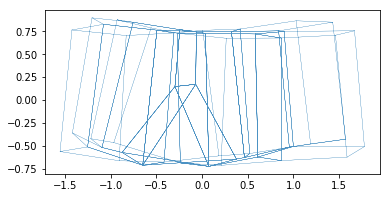

In [50]:
fig, ax = sheet_view(mono, mode='quick', coords=['x', 'z'], edge={'alpha': 0.8, 'lw': 0.2})
